<a href="https://colab.research.google.com/github/AnshUpadhyay639/Custom-Dataset-Implementation-in-PyTorch/blob/main/Custom_Dataset_implementation_in_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
torch.__version__

'2.5.1+cu121'

In [ ]:
# Device-Agnostic Code:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
# Import Raw Data from Github: Our Dataset consists of 3 Classes of Food.
import requests
import zipfile # Downloaded Data is in Zip Format.
from pathlib import Path

# Setup Path to a Data Folder:
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print("Skipped Download")
else:
  print("Data Directory Created")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download Data:
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip") # Raw Link Always.
    print("Downloading Data...")
    f.write(request.content)

  # Unzipping our Data:
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping Data")
    zip_ref.extractall(image_path)


Data Directory Created
Unzipping Data


In [ ]:
# Data Exploration:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): Path to the directory."""

  for dirpath, dirnames, filenames in os.walk(dir_path): # Directory Tree Generator.
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.


In [ ]:
# Setup Training and Testing Paths:
train_dir = image_path / "train"
test_dir = image_path / "test"
# Print Path:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

data/pizza_steak_sushi/train/pizza/393658.jpg
pizza
Image Size: (512, 383)


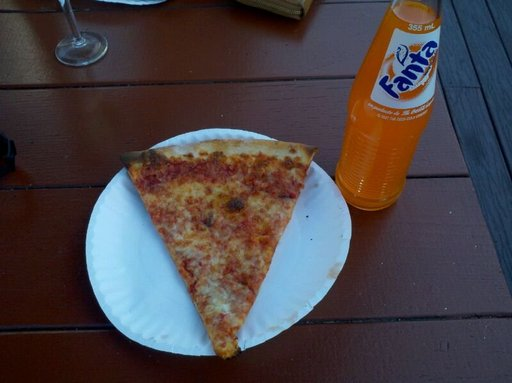

In [ ]:
# Visualize an Image:
import random
from PIL import Image # PIL --> Python Image Library. [NHWC] Format i.e.(Channels last).

#random.seed(42)
# Get all Image Paths:
image_path_list = list(image_path.glob("*/*/*.jpg")) # '*' --> means SELECT ALL directories/images/etc. (3 stars refer to the 3 sub-directories in image_path. # .glob() --> yield all the files matching the given pattern).
random_image_path = random.choice(image_path_list)
print(random_image_path)

# Getting Image Class (name of the exact directory where the image is located in) from path name:
image_class = random_image_path.parent.stem
print(image_class)

# Open Image: # Alternative: Use torchvision.io.read_image
  #from torchvision.io import read_image
  #read_image(random_image_path)
img = Image.open(random_image_path)
print(f"Image Size: {img.size}") # Alt: {img.height, img.width}
img

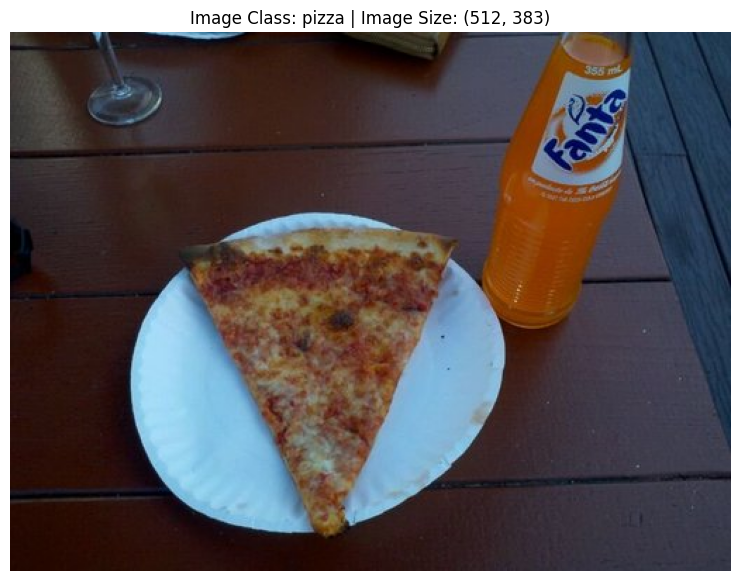

In [ ]:
import matplotlib.pyplot as plt
import numpy as np # Convert the image to ndarray for matplotlib.

img_array = np.array(img) # Convert PIL Image Object to a Numpy array

plt.figure(figsize=(10,7))
plt.imshow(img_array) # 'img' can also be directly used (Rare Cases).
plt.title(f"Image Class: {image_class} | Image Size: {img.size}")
plt.axis(False)
plt.show() # Optional

In [ ]:
# Transforming our Data into Tensors and then into Batches:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:
# Transform our Images from jpeg to Tensors:
data_transform = transforms.Compose([   # We can also use nn.Sequential() {They both works the same here}
                                     transforms.Resize((64,64)), # Resize the image to (64 x 64) pixels. [Model performes Faster but looses img details.]
                                     transforms.RandomHorizontalFlip(p=0.5), # Probability of flipping an image Horizontally is 50% [Data Augmentation Step]
                                     transforms.ToTensor() # Converts each pixel(0-255) to a Scalar Float Tensor(0.0 - 1.0) [NCHW format]
                                     ])

**Note:** *Data augmentation in deep learning is a technique that artificially increases data diversity and varying the size of a training set by creating new copies of data. This is done by making small changes to the existing data or using deep learning to generate new data points.*

In [ ]:
imgT = data_transform(img)  # Image converted to Tensor of Shape [3,64,64] but maptplotlib accepts Channels-last format so we can use permute()/reshape()/view().
imgT, imgT.shape, imgT.dtype

(tensor([[[0.1255, 0.1255, 0.1176,  ..., 0.1804, 0.2196, 0.2549],
          [0.1294, 0.1294, 0.1137,  ..., 0.1725, 0.2000, 0.2039],
          [0.1333, 0.1333, 0.1137,  ..., 0.2157, 0.2314, 0.2196],
          ...,
          [0.2118, 0.2157, 0.2235,  ..., 0.1451, 0.1412, 0.1412],
          [0.2078, 0.2078, 0.2196,  ..., 0.1451, 0.1412, 0.1412],
          [0.2039, 0.2039, 0.2078,  ..., 0.1412, 0.1373, 0.1373]],
 
         [[0.2275, 0.2275, 0.2118,  ..., 0.1216, 0.1922, 0.2353],
          [0.2314, 0.2314, 0.2118,  ..., 0.1333, 0.1843, 0.1882],
          [0.2392, 0.2353, 0.1961,  ..., 0.1922, 0.2235, 0.2118],
          ...,
          [0.2196, 0.2235, 0.2235,  ..., 0.0314, 0.0314, 0.0314],
          [0.2157, 0.2157, 0.2196,  ..., 0.0314, 0.0314, 0.0314],
          [0.2118, 0.2118, 0.2118,  ..., 0.0275, 0.0314, 0.0314]],
 
         [[0.3176, 0.3176, 0.3059,  ..., 0.0824, 0.1490, 0.1961],
          [0.3216, 0.3216, 0.3020,  ..., 0.1216, 0.1765, 0.1843],
          [0.3294, 0.3255, 0.2941,  ...,

<Figure size 1000x700 with 0 Axes>

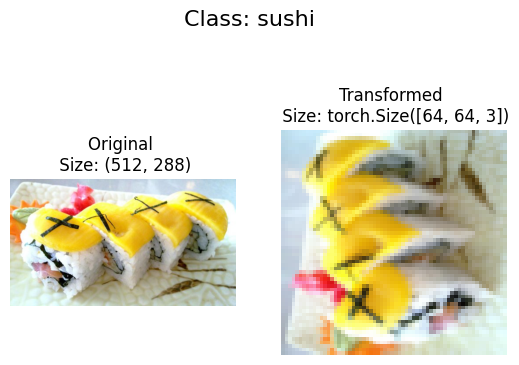

<Figure size 1000x700 with 0 Axes>

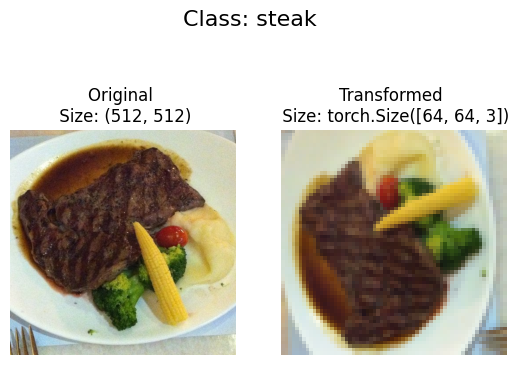

<Figure size 1000x700 with 0 Axes>

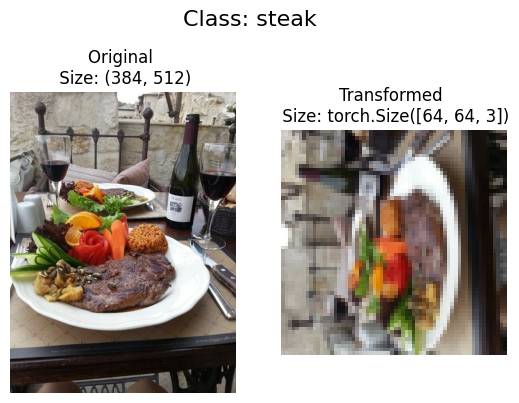

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None): # Selects 3 random images from 'image_paths'.
  """Select any random images from image_paths.
     Then plots the Original vs the Transformed images."""
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n) # Randomly select n image paths.
  for ipath in random_image_paths:
    with Image.open(ipath) as image:
      # Plot the OG Image:
      plt.figure(figsize=(10,7))
      fig, ax = plt.subplots(nrows = 1,ncols = 2) # Plot a Subplot for each Image. {returns the figure and a list of all axis(In this case: 1*2 = 2)}.
      ax[0].imshow(image)
      ax[0].set_title(f"Original \n Size: {image.size}") # Set a Title for an Axis.
      ax[0].axis("off") # Alternative.

      # Plot the Transformed Image:
      transformed_image = transform(image).permute(2,1,0) # Convert [NCHW] to [NHWC] format for matplotlib.
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \n Size: {transformed_image.shape}")
      ax[1].axis(False)

      # Create a Super title for our whole Figure:
      fig.suptitle(f"Class: {ipath.parent.stem}", fontsize=16)


plot_transformed_images(image_paths = image_path_list, transform = data_transform, n=3, seed = 42)

In [ ]:
# Loading our Image Data:
from torchvision.datasets import ImageFolder
train_data = ImageFolder(
    root = train_dir,
    transform = data_transform,
    target_transform = None) # By Default.

test_data = ImageFolder(root = test_dir, transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

**Note:** We didnt use **```torch.utils.data.DataLoader```** directly
because **'DataLoader'** requires an iterable dataset that can provide batches of data. While DataLoader handles batching and shuffling, it does not inherently know how to load or process image files or tensors unless we have a custom dataset ready. **'DataLoader'** needs an iterable object that knows how to load and return individual samples (images and labels).

So Instead we first used **```torchvision.datasets.ImageFolder```** which loads image along with their associated label if the given directory is in the **Standard Classification Image Format** ( where the folders are assigned the classes 0,1,2 in ascending order from the start ) as given below:

```
root/
├── class_1/
│   ├── img1.jpg
│   ├── img2.jpg
└── class_2/
    ├── img1.jpg
    ├── img2.jpg

```

In [ ]:
len(train_data), len(test_data), train_data.class_to_idx

(225, 75, {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
train_data.samples # Returns a List of {Feature, Label}.

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/12301.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1285298.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/138855.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1412034.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1524655.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1572608.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1633289.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1649276.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1654444.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1660415.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1899785.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1947572.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1968947.jpg',

In [ ]:
image, label = train_data[0][0], train_data[0][1] # For Sample at idx = 0 which returns a Tuple[img (idx=0), label (idx=1)]. ("__getitem__()" is in work in the Backend from 'ImageFolder' Class)
image, label

(tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
          [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
          [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
          ...,
          [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
          [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
          [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],
 
         [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
          [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
          [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
          ...,
          [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
          [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
          [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],
 
         [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
          [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
          [0.0902, 0.0902, 0.0902,  ...,

In [ ]:
train_data.classes[label], image.shape, image.dtype, type(label)

('pizza', torch.Size([3, 64, 64]), torch.float32, int)

In [ ]:
# Turn Loaded Images into DataLoader (or Iterables):
import os # For using the cpu_count() which tells us the no. of cores available for processing.
from torch.utils.data import dataloader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = os.cpu_count()) # num_workers = 0 (By Default)
test_dataloader = DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False, num_workers = 1)

len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
image, label = next(iter(train_dataloader))
image, label # According to Batch Size

(tensor([[[[0.3412, 0.3647, 0.3961,  ..., 0.3333, 0.3059, 0.3098],
           [0.2980, 0.3059, 0.3882,  ..., 0.3608, 0.4000, 0.3176],
           [0.3843, 0.3176, 0.3608,  ..., 0.4980, 0.4667, 0.3529],
           ...,
           [0.0706, 0.0784, 0.0784,  ..., 0.2235, 0.2353, 0.2314],
           [0.0471, 0.0510, 0.0549,  ..., 0.0706, 0.0706, 0.0706],
           [0.0588, 0.0588, 0.0549,  ..., 0.0235, 0.0235, 0.0235]],
 
          [[0.1451, 0.1686, 0.1804,  ..., 0.2039, 0.1922, 0.1961],
           [0.1255, 0.1333, 0.1804,  ..., 0.2431, 0.2941, 0.2078],
           [0.1608, 0.1373, 0.1686,  ..., 0.3804, 0.3529, 0.2314],
           ...,
           [0.0353, 0.0353, 0.0353,  ..., 0.1176, 0.1255, 0.1294],
           [0.0235, 0.0235, 0.0235,  ..., 0.0314, 0.0314, 0.0314],
           [0.0275, 0.0275, 0.0275,  ..., 0.0157, 0.0118, 0.0118]],
 
          [[0.0824, 0.0784, 0.0863,  ..., 0.0980, 0.1020, 0.1059],
           [0.0706, 0.0745, 0.0902,  ..., 0.1490, 0.1922, 0.1098],
           [0.0902, 0.07

In [ ]:
image.shape, label.shape # DataLoader added a Batch Size in our Initial Shape of both Image and Labels (before Label had no shape).

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

In [ ]:
#Alternative: Loading our Images with a Custom Dataset (instead of using 'ImageFolder'):
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset # Subclassed by literally every Custom Dataset Class.
from torchvision import transforms
from typing import Tuple, Dict, List # These are generic types that also allows you to specify the types of elements inside the container e.g(Dict[str,int]).

**Note:** Now we make use of **```os.scandir```** *(returns a list of Folder names in the given Directory)* to traverse a target directory ( assuming our data structure is in the Standard Image Classification Format) to fetch the class names and then convert all the labels into a List to replicate the **```Dataset.classes```** and **```Dataset.class_to_idx```** functionality.

In [ ]:
# Setup Path for Training data:
target_directory = train_dir
class_names_found = sorted(entry.name for entry in os.scandir(target_directory)) # entry.name --> fetches the name of the Folder
class_names_found

['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory"""
  # For creating a List of Classes:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir()) # Checking if Directory exists is also a Good Practice.
  if not classes:
    raise FileNotFoundError(f"No Classes Found in {directory} Please verify the File Structure again...")

  # For creating a Class/Idx Dixtionary:
  class_to_idx = {class_name : i     for i, class_name in enumerate(classes)} # {class_name : i} is the dictionary where...
  return classes, class_to_idx

find_classes(train_dir) # returns a Tuple.

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [ ]:
# Create a Custom Dataset to replicate the 'ImageFolder":
class ImageFolderCustom(torch.utils.data.Dataset): # If u subclass this u have to overwrite the inbuilt '__getitem__()' and '__len()__' functions suited for your own custom data.
  def __init__(self, target_dir: str, transform: None): # target_dir is either of Train or Test.
    # Create class attributes
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg")) # Fetches all images in either Test or Train Directories (1ST '*' chooses any/all from the 3 Class folders and the 2ND '*' chooses any/all image within that folder).
    # Setup Transforms (Optional):
    self.transform = transform
    # Setup Classes and Class_to_idx:
    self.classes, self.class_to_idx = find_classes(target_dir) # Make use of our Custom 'find_classes' function.

  # Create a function for Load Images:
  def load_image(self, index: int) -> Image.Image: # Returns a PIL Image.
    """Loads in an image from a given index."""
    image_path = self.paths[index]
    return Image.open(image_path)

  # Overwritting "__len()__" [Optional]:
  def __len__(self):
    """Returns the total number of samples."""
    return len(self.paths)

  #Overwritting "__getitem__()" [Required]:
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]: # Remember this default return type format i.e {Feature : Label}.
    """Returns a target sample (image/label) at a given index."""
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # Expects a Standard Image Classification Structured Path.
    class_idx = self.class_to_idx[class_name] # A Dict that returns the index of a Class.

    # Transform Image [Optional]:
    if self.transform:
      return self.transform(img), class_idx # We return Labels in the form of numbers i.e(Indexes).
    else:
      return img, class_idx # Returns an Untransformed Image and Label.

In [ ]:
train_data_custom = ImageFolderCustom(target_dir = train_dir, transform = data_transform)
test_data_custom = ImageFolderCustom(target_dir = test_dir, transform = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])) #Alternative
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fabbcd48790>,
 <__main__.ImageFolderCustom at 0x7fabbcbfbd50>)

In [ ]:
len(train_data_custom), len(test_data_custom) # Same as Before. YAY!

(225, 75)

In [ ]:
train_data_custom.classes, train_data_custom.class_to_idx, train_data_custom.__len__() # Letss GOOO!

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2}, 225)

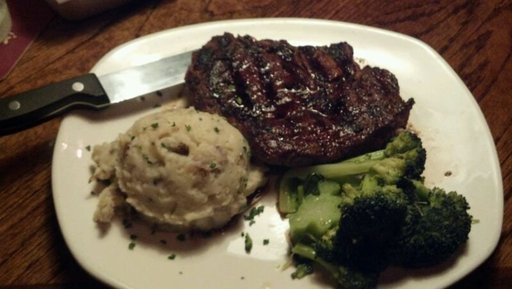

In [ ]:
train_data_custom.load_image(0) # Returns a OG PIL Image.

In [ ]:
train_data_custom[0] # "__getitem__()" gets called automatically.

(tensor([[[0.2431, 0.2706, 0.3098,  ..., 0.0980, 0.1412, 0.2941],
          [0.2000, 0.2275, 0.2824,  ..., 0.1098, 0.1725, 0.3647],
          [0.2353, 0.2118, 0.2431,  ..., 0.1176, 0.2118, 0.4314],
          ...,
          [0.1059, 0.0902, 0.0471,  ..., 0.2392, 0.2667, 0.2549],
          [0.0863, 0.0784, 0.0471,  ..., 0.2078, 0.2275, 0.2314],
          [0.0902, 0.0863, 0.0549,  ..., 0.1451, 0.1490, 0.1569]],
 
         [[0.1020, 0.1216, 0.1490,  ..., 0.0314, 0.0510, 0.2314],
          [0.0745, 0.0980, 0.1373,  ..., 0.0314, 0.0824, 0.3098],
          [0.1020, 0.0824, 0.1098,  ..., 0.0314, 0.1176, 0.3882],
          ...,
          [0.0392, 0.0392, 0.0235,  ..., 0.1137, 0.1373, 0.1216],
          [0.0392, 0.0314, 0.0235,  ..., 0.0980, 0.1137, 0.1137],
          [0.0392, 0.0353, 0.0275,  ..., 0.0588, 0.0588, 0.0706]],
 
         [[0.0706, 0.0667, 0.0824,  ..., 0.0549, 0.0588, 0.1608],
          [0.0510, 0.0627, 0.0824,  ..., 0.0510, 0.0706, 0.2157],
          [0.0588, 0.0510, 0.0706,  ...,

In [ ]:
# Create a function to Display Random Samples:
def display_random_images(dataset: torch.utils.data.dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = None,
                          seed: int = None):
  # Adjust Displaying of Images:
  if n > 10:
    n = 10
    display_shape = False
    print(f"Too much Images to Display!")

  # Set the Random Seed:
  if(seed):
    random.seed(seed)

  # Get indexes of Random Samples:
  random_samples_idx = random.sample(range(len(dataset)), k = n) # Returns a List.

  # Setup up a Figure:
  plt.figure(figsize=(16,8))

  # Loop through the random indexes and plot them:
  for i, sample in enumerate(random_samples_idx):
    image, label = dataset[sample][0], dataset[sample][1] # Each sample return a Tuple[img,label].
    image = image.permute(2,1,0) # Convert to Channels-Last Format for matplotlib.
    plt.subplot(1, n, i+1) # Plot image at Axis : i++
    plt.imshow(image)
    plt.axis(False)

    if classes:
      text = f"Class: {classes[label]}" # f-String
      if display_shape:
        text += f"\n Shape: {image.shape}"
    # Plot the Title:
    plt.title(text)

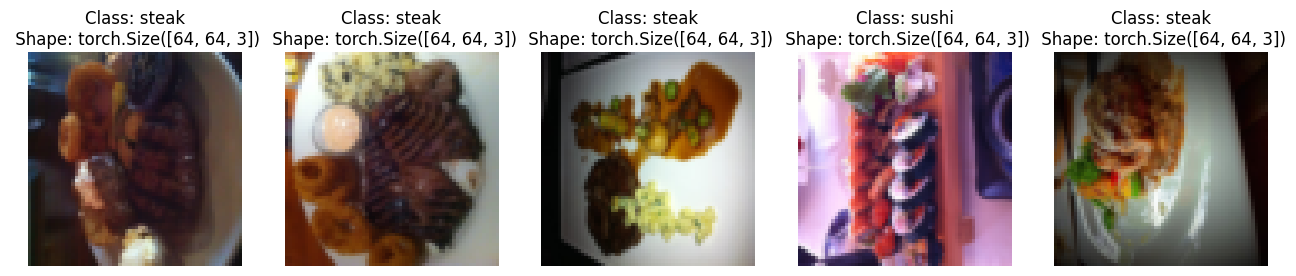

In [ ]:
# Display random images:
display_random_images(dataset = train_data_custom, classes = train_data_custom.classes, n=5, display_shape = True, seed = None)

In [ ]:
# Batchify our Custom Dataset using DataLoader:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
N_WORKERS = os.cpu_count()
train_data_custom_dataloader = DataLoader(dataset = train_data_custom, batch_size = BATCH_SIZE, num_workers = 1, shuffle = True)
test_data_custom_dataloader = DataLoader(dataset = test_data_custom, batch_size = BATCH_SIZE, num_workers = 0, shuffle = False)
train_data_custom_dataloader, test_data_custom_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fabbcfb84d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fabbd1e2410>)

In [ ]:
# Get a Sample:
image_custom, label_custom = next(iter(train_data_custom_dataloader)) # Fetches the First Batch as next() is called Only Once.
print(image_custom[31], label_custom[31]) # Printing Last Sample(img,label) from 1st batch
image_custom.shape, label_custom.shape # Printing Output Shapes.

tensor([[[0.9765, 0.9843, 0.9882,  ..., 0.0667, 0.0706, 0.0784],
         [1.0000, 1.0000, 1.0000,  ..., 0.0667, 0.0706, 0.0745],
         [1.0000, 1.0000, 1.0000,  ..., 0.0706, 0.0745, 0.0745],
         ...,
         [0.7882, 0.7882, 0.7686,  ..., 0.6510, 0.6471, 0.6275],
         [0.7961, 0.7961, 0.7882,  ..., 0.6667, 0.6471, 0.6275],
         [0.7647, 0.7804, 0.7765,  ..., 0.6784, 0.6510, 0.6314]],

        [[0.9608, 0.9725, 0.9804,  ..., 0.0627, 0.0667, 0.0667],
         [1.0000, 1.0000, 1.0000,  ..., 0.0627, 0.0667, 0.0667],
         [1.0000, 1.0000, 1.0000,  ..., 0.0667, 0.0627, 0.0627],
         ...,
         [0.7020, 0.7020, 0.6745,  ..., 0.2549, 0.1765, 0.1373],
         [0.7098, 0.7098, 0.7020,  ..., 0.2157, 0.1686, 0.1255],
         [0.6784, 0.6902, 0.6824,  ..., 0.1882, 0.1529, 0.1216]],

        [[0.9647, 0.9725, 0.9843,  ..., 0.0902, 0.0941, 0.0902],
         [1.0000, 1.0000, 1.0000,  ..., 0.0902, 0.0941, 0.0902],
         [1.0000, 1.0000, 1.0000,  ..., 0.0941, 0.0863, 0.

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [ ]:
# More Data Augmentation Techniques:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31), # Performs Random Various Types of PyTorch.Transformations Automatically for you. (Intensity of Aug. = 0-31(MAX)).
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

In [ ]:
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/673127.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1627703.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1016217.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2117351.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg')]

<Figure size 1000x700 with 0 Axes>

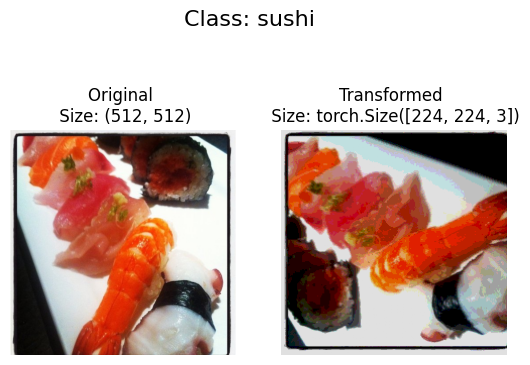

<Figure size 1000x700 with 0 Axes>

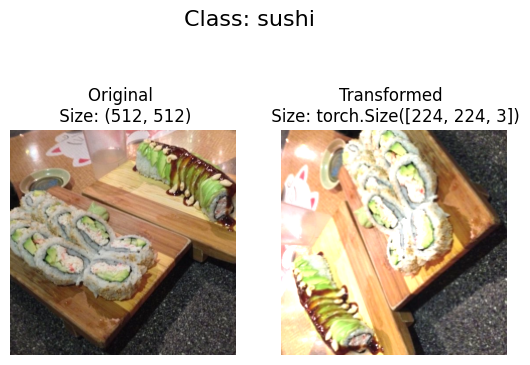

<Figure size 1000x700 with 0 Axes>

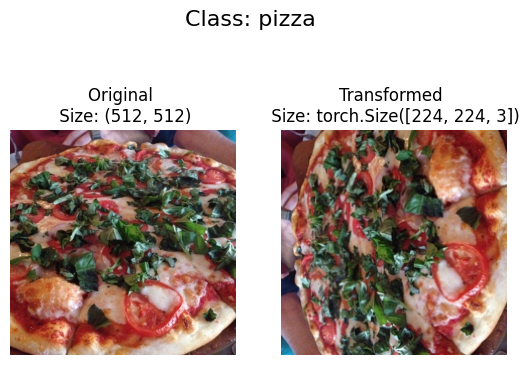

In [ ]:
# Plot Random Transformed Images:
plot_transformed_images(image_paths = image_path_list, transform = train_transform, n=3, seed = None) # This seed cannot control reproducibility of "transforms.TrivialAugmentWide()".

In [ ]:
# Create a Tiny VGG Architectural Model:
import torch
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.conv_block_3 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 0),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units, out_channels = hidden_units, kernel_size = 3, stride = 1, padding = 0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )

    self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(in_features = hidden_units*4*4, out_features = output_shape))

  def forward(self, x):
    return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))) # This single step benefits from Operator Fusion.

# Create an Instance:
model_0 = TinyVGG(input_shape = 3, hidden_units = 20, output_shape = len(train_data.classes)).to(device) # No. of O/P Classes = 3.
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=320, out_features=3, bias=True)
  )
)

In [ ]:
# Fetch Model Summary: This is useful for Calculating the "in_features" of Linear Layer provided corresponding to any Input Sample with Shape provided.
try:
  import torchinfo
except: # This Snippet executes only if an Error is Found (Diff from 'else' block)
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size = (1, 3, 64, 64)) # This will throw an Error if wrong input shape is provided.[Note: In the figure below it also shows the computed O/P shape of nn.Sequential() so dont get confused.]

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 20, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 20, 62, 62]           560
│    └─ReLU: 2-2                         [1, 20, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 20, 60, 60]           3,620
│    └─ReLU: 2-4                         [1, 20, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 20, 30, 30]           --
├─Sequential: 1-2                        [1, 20, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 20, 28, 28]           3,620
│    └─ReLU: 2-7                         [1, 20, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 20, 26, 26]           3,620
│    └─ReLU: 2-9                         [1, 20, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 20, 13, 13]           --
├─Seq

In [ ]:
# Create a Simple Transform:
simple_transform = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()])

In [ ]:
# Load and Transform Image Data using ImageFolder:
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root = train_dir, transform = simple_transform)
test_data_simple = datasets.ImageFolder(root = test_dir, transform = simple_transform)

In [ ]:
# Turn Datasets into DataLoader to Batchify them:
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 12
N_WORKERS = os.cpu_count()
train_dataloader_simple = DataLoader(dataset = train_data_simple, batch_size = BATCH_SIZE, num_workers = N_WORKERS, shuffle = True)
test_dataloader_simple = DataLoader(dataset = test_data_simple, batch_size = BATCH_SIZE, num_workers = N_WORKERS, shuffle = False)

In [ ]:
def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device: torch.device):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      y_pred = model(X)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim = 1), dim = 1)
      test_acc += (y_pred_class == y).sum().item()/len(y_pred)

  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

In [ ]:
# Create another functions that combines the 'train-step' and 'test-step' functions:
from tqdm.auto import tqdm
def traintest(model: torch.nn.Module,
              train_dataloader: torch.utils.data.DataLoader,
              test_dataloader: torch.utils.data.DataLoader,
              optimizer: torch.optim.Optimizer,
              loss_fn: torch.nn.Module,
              epochs: int,
              device: torch.device = None)->dict[str, list[float]]:

  # Create a Dictionary to save intermediate metrices:
  results = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

  # Create a loop:
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model, dataloader = train_dataloader, loss_fn = loss_fn, optimizer = optimizer, device = device)
    test_loss, test_acc = test_step(model = model, dataloader = test_dataloader, loss_fn = loss_fn, device = device)
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [ ]:
from timeit import default_timer as timer
s = timer()

# Train and Evaluate our Model_0:
torch.manual_seed(42) # Not Recommended for Large Models.
model_0_results = traintest(model = model_0,
          train_dataloader = train_dataloader_simple,
          test_dataloader = test_dataloader_simple,
          optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001),
          loss_fn = torch.nn.CrossEntropyLoss(),
          epochs = 5,
          device = device)

e = timer()
print(f"Total Time Taken: {e-s:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1008 | Train Acc: 0.3041 | Test Loss: 1.0903 | Test Acc: 0.4762
Epoch: 1 | Train Loss: 1.0886 | Train Acc: 0.3406 | Test Loss: 1.0810 | Test Acc: 0.3333
Epoch: 2 | Train Loss: 1.0145 | Train Acc: 0.4678 | Test Loss: 0.9720 | Test Acc: 0.5476
Epoch: 3 | Train Loss: 0.9449 | Train Acc: 0.5132 | Test Loss: 0.9544 | Test Acc: 0.5714
Epoch: 4 | Train Loss: 0.8753 | Train Acc: 0.5775 | Test Loss: 0.9897 | Test Acc: 0.4048
Total Time Taken: 31.821 seconds


In [ ]:
# Print the Results Alternatively:
model_0_results.keys(), model_0_results.values()

(dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc']),
 dict_values([[1.1007963167993646, 1.0886033396971853, 1.0144799665400857, 0.9448759712670979, 0.875318822107817], [0.3040935672514619, 0.34064327485380125, 0.46783625730994144, 0.5131578947368421, 0.5774853801169592], [1.090266398021153, 1.0810025419507707, 0.9719886098589215, 0.9544357742582049, 0.9896757262093681], [0.47619047619047616, 0.3333333333333333, 0.5476190476190477, 0.5714285714285714, 0.40476190476190477]]))

In [ ]:
# Plot the Model's Loss Curve [A way of tracking your Model's Progress over time]:
def plot_loss_curves(results: Dict[str, List[float]]): # Alternative by using 'typing' module for type-hints.
  """Plot Training Curves of a Results Dictionary against No. of Steps/Epochs"""

  # Get Loss values for Train and Test:
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get Accuracy values for Train and Test:
  acc = results["train_acc"]
  test_acc = results["test_acc"]

  # Get the No. of Epochs:
  epochs = range(len(loss)) # Gives O/P: range(0, 10)

  # Setup the Plot:
  plt.figure(figsize=(10,7))

  # Plot the Loss:
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label = "Train Loss")
  plt.plot(epochs, test_loss, label = "Test Loss")
  plt.title("Loss Graph")
  plt.xlabel("Epochs")
  plt.ylabel("Loss Values")
  plt.legend()

  # Plot the Accuracy:
  plt.subplot(1,2,2)
  plt.plot(epochs, acc, label = "Train Accuracy")
  plt.plot(epochs, test_acc, label = "Test Accuracy")
  plt.title("Accuracy Graph")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy Values")
  plt.legend()

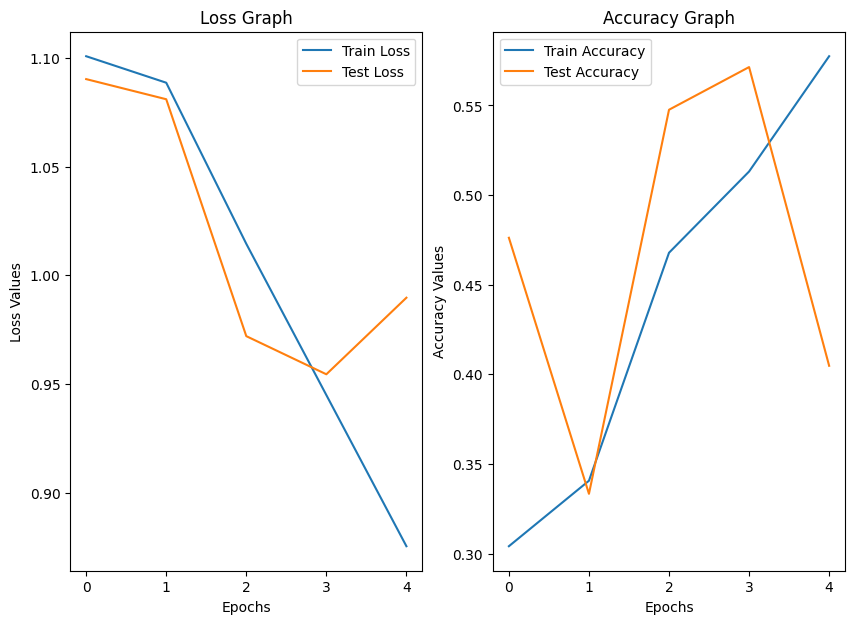

In [ ]:
plot_loss_curves(model_0_results) # Loss Curves tells if our Model is Overfitting or Underfitting.

**Note:** To reduce Overfitting (Model preforming best on Train Data and fails on Test) we will make another Model with Data Augmentations.

In [ ]:
# More Complex Data Augmentation:
from torchvision import transforms

train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31), # Performs Random Various Types of PyTorch.Transformations Automatically for you. (Intensity of Aug. = 0-31(MAX)).
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([ # We never Augment Test Sample (Only necessary Transformations).
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

In [ ]:
# Create Train and Test Dataset and DataLoader:
train_data_augmented = ImageFolder(root = train_dir, transform = train_transform_trivial)
test_data_simple = ImageFolder(root = test_dir, transform = test_transform_simple)

train_dataloader_augmented = DataLoader(dataset = train_data_augmented, batch_size = 32, num_workers = os.cpu_count(), shuffle = True)
test_dataloader_simple = DataLoader(dataset = test_data_simple, batch_size = 32, num_workers = os.cpu_count(), shuffle = False)

In [ ]:
# Create a new Instance of TingVGG Class:
model_1 = TinyVGG(input_shape = 3, hidden_units = 10, output_shape = len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=3, bias=True)
  )
)

In [ ]:
summary(model_1,input_size = [1,3,64,64]) # Printing Model Summary.

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
s = timer()

model_1_results = traintest(model = model_1,
                            train_dataloader = train_dataloader_augmented,
                            test_dataloader = test_dataloader_simple,
                            optimizer = torch.optim.Adam(model_1.parameters(), lr = 0.001),
                            loss_fn = torch.nn.CrossEntropyLoss(),
                            epochs = 5,
                            device = device)

e = timer()
print(f"Total Time Taken: {e-s:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 1.1025 | Train Acc: 0.2930 | Test Loss: 1.1075 | Test Acc: 0.1979
Epoch: 1 | Train Loss: 1.0969 | Train Acc: 0.2930 | Test Loss: 1.1093 | Test Acc: 0.2604
Epoch: 2 | Train Loss: 1.0922 | Train Acc: 0.4258 | Test Loss: 1.1141 | Test Acc: 0.2604
Epoch: 3 | Train Loss: 1.1001 | Train Acc: 0.3047 | Test Loss: 1.1194 | Test Acc: 0.2604
Epoch: 4 | Train Loss: 1.0881 | Train Acc: 0.4258 | Test Loss: 1.1264 | Test Acc: 0.2604
Total Time Taken: 23.056 seconds


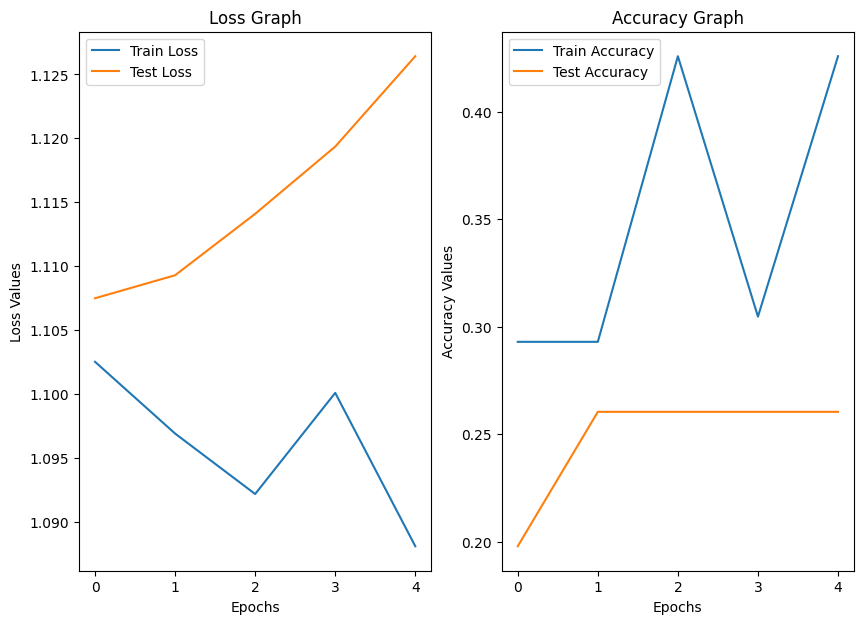

In [ ]:
# Plot the Loss Curves:
plot_loss_curves(model_1_results)

**Note:** It seems like our Model is Both ***Underfitting*** and ***Overfitting***.

<Axes: title={'center': 'Model 1'}>

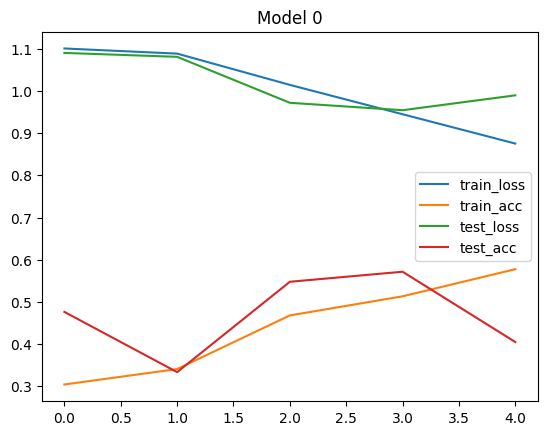

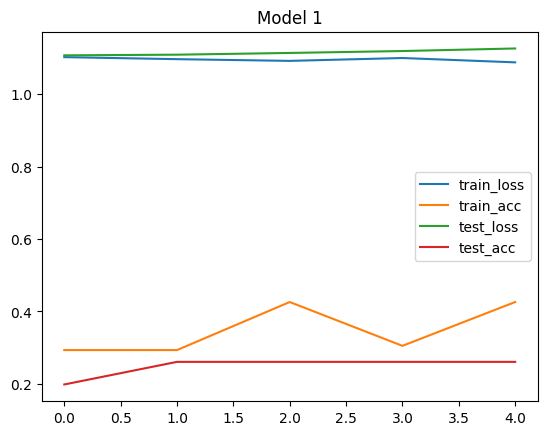

In [ ]:
# Comparing our Model results with each other:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

# Dataframe provides Direct Plotting instead of making figure and subplots.
model_0_df.plot(title = "Model 0")
model_1_df.plot(title = "Model 1")

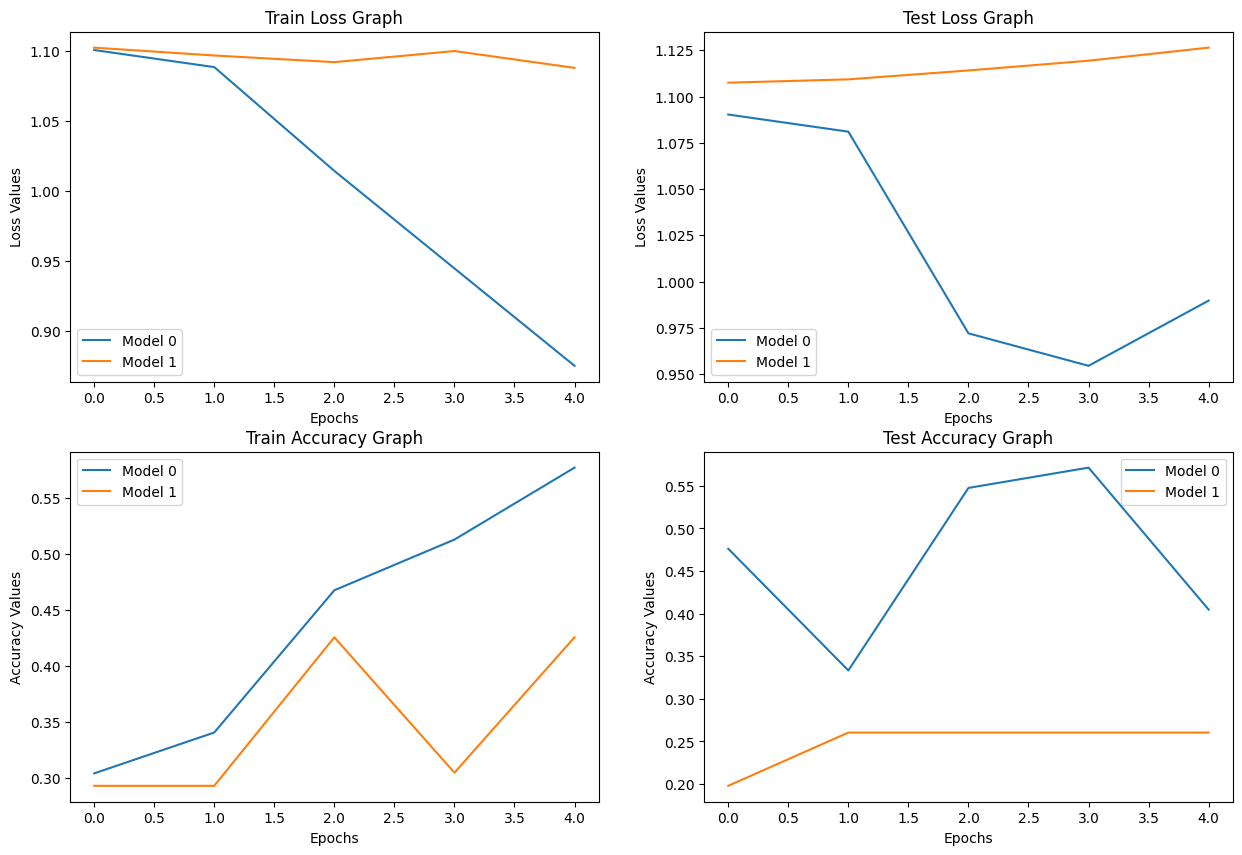

In [ ]:
# General Plotting:
plt.figure(figsize=(15,10))
epochs = range(len(model_0_df))

plt.subplot(2,2,1)
plt.plot(epochs, model_0_df["train_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["train_loss"], label = "Model 1")
plt.title("Train Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss Values")
plt.legend()

plt.subplot(2,2,2)
plt.plot(epochs, model_0_df["test_loss"], label = "Model 0")
plt.plot(epochs, model_1_df["test_loss"], label = "Model 1")
plt.title("Test Loss Graph")
plt.xlabel("Epochs")
plt.ylabel("Loss Values")
plt.legend()

plt.subplot(2,2,3)
plt.plot(epochs, model_0_df["train_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["train_acc"], label = "Model 1")
plt.title("Train Accuracy Graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Values")
plt.legend()

plt.subplot(2,2,4)
plt.plot(epochs, model_0_df["test_acc"], label = "Model 0")
plt.plot(epochs, model_1_df["test_acc"], label = "Model 1")
plt.title("Test Accuracy Graph")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Values")
plt.legend()

In [ ]:
# Making a function that Makes a Raw Random Real life Image ready for our Model Prediction:
import torchvision
def pred_plot_image(model: torch.nn.Module,
                    image_path: str,
                    class_names: List[str] = None,
                    transform = torchvision.transforms.Compose([transforms.Resize((64,64))]),
                    device = device):
  """Makes Prediction on a Target Image (Neither in Test or Train Datasets) with a trained Model and plots the Image and its Prediction"""
  # Load the Target Image:
  target_image = torchvision.io.decode_image(str(image_path)).type(torch.float32) # Converts Image to Tensor Automatically

  # Divivde the image pixels by 255 to get them in range(0,1):
  target_image = target_image/255.0

  # Transform Image if necessary:
  if transform:
    target_image = transform(target_image)

  # Change Model and Image to Device:
  model.to(device)
  target_image = target_image.to(device)

  # Make a Prediction:
  with torch.inference_mode():
    target_image = target_image.unsqueeze(dim = 0) # Add a Batch Channel Dimension for input to our Model.
    target_image_pred = model(target_image)

    # Convert Logits to Predicted Probabilities:
    target_image_pred_probs = torch.softmax(target_image_pred, dim = 1)

    # Convert Predicted Probabilities to Predicted Labels:
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim = 1)

    # Plot the Image:
    plt.imshow(target_image.squeeze().permute(1,2,0)) # Remove Batch Dimnesion and Switch to Channels Last Image Format.

    if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max():.3f}" # Matplotlib cannot handle things on the GPU.
    else:
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max():.3f}"

    plt.title(title)
    plt.axis(False)